In [1]:
# Step 1: Let's import some libraries and say hi!

import numpy as np     # <----- Our old friend
import itertools

import torch            # |  Our new best friends -- this is the main pytroch library
import torch.nn as nn   # |  This is just shortening the name of this module since we're gonna use it a lot -- this is the one that has neural network objects (nn.modules)
import torchvision      # |  This is for importing the vision datasets we'll use
from torch.utils.data import Dataset, DataLoader, random_split, Subset # | These are particular objects that we use to load our data (and shuffle it and whatnot) we'll talk more about these later
import torchvision.transforms as tt # | Allows us to transform our data while we load it (or after) such as rotating, flipping, ocluding, etc. 
from torchvision.datasets import ImageFolder # | ^^ less important for you
import torchvision.models as models

import torch.nn.functional as F # | This is for functional / in-place operations for example if I wanted to do a sigmoid operation, but not as a neural net object (though I can still update through it)



from torchvision.utils import make_grid  # |   Utility stuff for plotting
import matplotlib.pyplot as plt          # |  <- I use this one a lot for plotting, seaborn is a good alternative
from matplotlib.image import imread      # |  it reads images... (png -> usable input (like a numpy array for ex))
import os
import random
from tqdm import tqdm  # | This one is a cute one for making a loading bar, I like it and we'll use it here

%matplotlib inline
device = torch.device('mps')


In [21]:
# Hyperparameters
BATCH_SIZE = 20
LR = .001
EPOCHS = 1
K = 5

In [3]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, images_folder, labels_file, transform=None):
        self.images_folder = images_folder
        self.labels = self.read_labels(labels_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_name, label = self.labels[idx]
        image_path = os.path.join(self.images_folder, image_name)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    def read_labels(self, labels_file):
        labels = []
        with open(labels_file, 'r') as file:
            count = 0
            for line in file:
                parts = line.strip().split()  # Assuming each line has image name and label separated by space
                label = float(parts[1])  # Assuming labels are integers
                labels.append((f"frame_{count:04d}.png", label))
                count += 1
        return labels

def loaddataset(folder, batch_size):
    images_folder = folder
    labels_file = "labeled/0.txt"
    transform = None  # You can define transformations here if needed (e.g., torchvision.transforms.ToTensor())

    transform = transforms.Compose([
    transforms.Resize((109, 146)),  # Resize image to a square 256x256
    transforms.ToTensor()  # Convert image to tensor
    ])

    dataset = CustomDataset(images_folder, labels_file, transform)

# Create a DataLoader to iterate over the dataset

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataset, dataloader


In [4]:
def plot_image_and_label(image, label):
    
    '''
    Takes in an image and label and shows them using matplotlib 
    this is used to visualize the data and also the outputs of our network
    '''
    image = image.permute(1, 2, 0)

    plt.imshow(image)
    plt.title("Label = " + str(label))
    plt.show()
    return

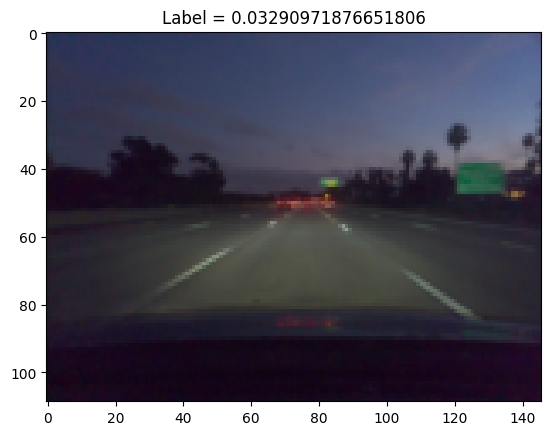

In [44]:
train_dataset, train_dataloader = loaddataset(folder='vid0_frames', batch_size=BATCH_SIZE)
foldSizes = [len(train_dataset) // K] * K
foldSizes[-1] += len(train_dataset) - sum(foldSizes)
folds = random_split(train_dataset, foldSizes)
test_dataset = folds[0]
train_datasets = [fold for i, fold in enumerate(folds) if i != 0]
train_dataset = torch.utils.data.ConcatDataset(train_datasets)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
ex_image, ex_label = train_dataset[random.randint(0,1000)]
plot_image_and_label(ex_image, ex_label)

In [23]:
#  Load the model

model = models.resnet50(pretrained=True, progress=True)

#  Freeze all parameters in the base model

for param in model.parameters():
   param.requires_grad = False

# Replace FC layer with custom layer

model.fc = nn.Sequential(nn.Dropout(),
                         nn.Linear(model.fc.in_features, 1),
                         nn.Sigmoid())

# Train, optimize only FC layer
model.train()
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=LR)

# Eval and save best model
model.eval()
# torch.save(model.state_dict(), 'state.pth')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
# Load state dict of last model
# model.load_state_dict(torch.load())
model = model.to(device)

# Freeze parameters only in fully conected layer
for param in model.fc.parameters():
    param.requires_grad = False
for param in model.parameters():
    if param != model.fc.parameters():
        param.requires_grad = True

# Train, optimize all layers except FC
base_parameters = [model.conv1.parameters(),
                   model.bn1.parameters(),
                   model.layer1.parameters(),
                   model.layer2.parameters(),
                   model.layer3.parameters(),
                   model.layer4.parameters()]
optimizer = torch.optim.SGD(itertools.chain(*base_parameters), lr=LR)

In [30]:
losses = []

for epoch in range(EPOCHS):
    for i, (image, label) in enumerate(tqdm(iter(train_dataloader))):
        image = image.to(device, torch.float32)
        label = label.to(device, torch.float32)
        optimizer.zero_grad()
        output = model(image)
        loss = .5*((output - label)**2)
        loss.mean().backward()
        optimizer.step()
        losses.append(loss.mean().item())
        if i % 10 == 0:
            print(loss.mean())

print(losses)

  2%|▏         | 1/48 [00:01<00:48,  1.04s/it]

tensor(0.0022, device='mps:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 11/48 [00:07<00:24,  1.52it/s]

tensor(0.0017, device='mps:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 21/48 [00:14<00:17,  1.57it/s]

tensor(0.0008, device='mps:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 31/48 [00:20<00:10,  1.55it/s]

tensor(0.0006, device='mps:0', grad_fn=<MeanBackward0>)


 85%|████████▌ | 41/48 [00:27<00:04,  1.49it/s]

tensor(0.0005, device='mps:0', grad_fn=<MeanBackward0>)


100%|██████████| 48/48 [00:31<00:00,  1.52it/s]

[0.002218435285612941, 0.0017372005386278033, 0.0013767778873443604, 0.0016937049804255366, 0.0019219499081373215, 0.0019362795865163207, 0.0014999537961557508, 0.0008405881235376, 0.001435986370779574, 0.0010306744370609522, 0.0016631438629701734, 0.0010838134912773967, 0.0009238497586920857, 0.0009807480964809656, 0.0009021504083648324, 0.0013999736402183771, 0.000997267896309495, 0.0009695240878500044, 0.0006940758321434259, 0.0009819138795137405, 0.0007942221709527075, 0.0007568709552288055, 0.0008506712038069963, 0.0006934453267604113, 0.0005307723768055439, 0.0006172037101350725, 0.0007786426576785743, 0.00067778310040012, 0.000680141500197351, 0.0005800005164928734, 0.000565681024454534, 0.0004931992734782398, 0.000637161429040134, 0.0006886223563924432, 0.000569804513361305, 0.0004852563433814794, 0.00033326365519315004, 0.0005397398490458727, 0.0004599937819875777, 0.00032519683009013534, 0.00047368311788886786, 0.00041672951192595065, 0.0004943771054968238, 0.0003222762024961

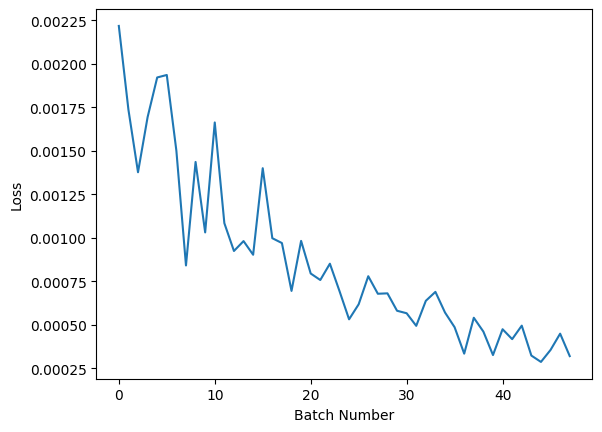

In [31]:
batch_number = []
for i in range(len(losses)):
    batch_number.append(i)

plt.plot(batch_number, losses)

plt.xlabel("Batch Number")
plt.ylabel("Loss")

plt.show()

[2.218435285612941, 1.7372005386278033, 1.3767778873443604, 1.6937049804255366, 1.9219499081373215, 1.9362795865163207, 1.4999537961557508, 0.8405881235376, 1.435986370779574, 1.0306744370609522, 1.6631438629701734, 1.0838134912773967, 0.9238497586920857, 0.9807480964809656, 0.9021504083648324, 1.3999736402183771, 0.997267896309495, 0.9695240878500044, 0.6940758321434259, 0.9819138795137405, 0.7942221709527075, 0.7568709552288055, 0.8506712038069963, 0.6934453267604113, 0.5307723768055439, 0.6172037101350725, 0.7786426576785743, 0.67778310040012, 0.680141500197351, 0.5800005164928734, 0.565681024454534, 0.4931992734782398, 0.637161429040134, 0.6886223563924432, 0.569804513361305, 0.4852563433814794, 0.33326365519315004, 0.5397398490458727, 0.4599937819875777, 0.32519683009013534, 0.47368311788886786, 0.41672951192595065, 0.4943771054968238, 0.3222762024961412, 0.28567510889843106, 0.35458928323350847, 0.4482524818740785, 0.3191233263351023]
[2218.435285612941, 1737.2005386278033, 1376.

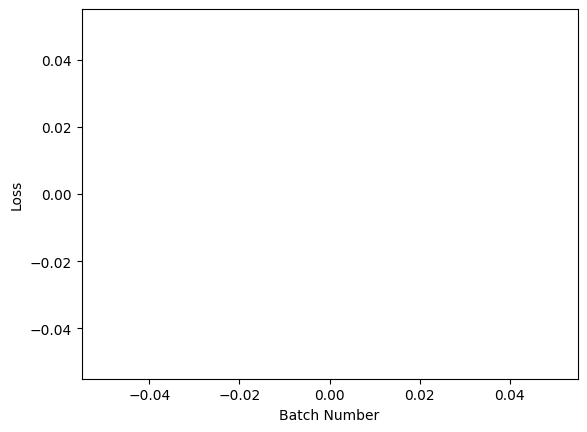

In [33]:
batch_number = []
for i in range(len(losses)):
    batch_number.append(i)

print(losses)
losses = list(map(lambda x : x * 1000, losses))
print(losses)

plt.plot(batch_number[50:], losses[50:])

plt.xlabel("Batch Number")
plt.ylabel("Loss")

plt.show()

In [34]:
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)
def load_model(model, file_path):
    model.load_state_dict(torch.load(file_path))

In [35]:
save_model(model, './best_resnet')

In [36]:
load_model(model, './best_resnet')

In [47]:
# test_dataloader = loaddataset(folder='vid1_frames', batch_size=1)
for i, (image, label) in enumerate(tqdm(iter(test_dataloader))):
    image = image.to(device, torch.float32)
    label = label.to(device, torch.float32)
    optimizer.zero_grad()
    loss = .5*((output - label)**2)
    print(loss, label)

  2%|▏         | 5/240 [00:00<00:11, 20.83it/s]

tensor([[1.7671e-04],
        [1.1830e-04],
        [2.0035e-04],
        [4.3496e-04],
        [9.5397e-05],
        [1.0009e-03],
        [4.9615e-04],
        [1.0634e-04],
        [1.9023e-04],
        [1.8991e-04],
        [9.1760e-05],
        [3.2752e-04],
        [1.4351e-03],
        [2.0426e-04],
        [1.5158e-04],
        [1.9114e-04],
        [9.7170e-04],
        [2.2336e-04],
        [1.3600e-04],
        [7.3381e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0297], device='mps:0')
tensor([[1.3715e-04],
        [8.6382e-05],
        [1.5806e-04],
        [3.7146e-04],
        [6.6992e-05],
        [9.0325e-04],
        [4.2816e-04],
        [7.6207e-05],
        [1.4909e-04],
        [1.4881e-04],
        [6.3950e-05],
        [2.7276e-04],
        [1.3177e-03],
        [1.6154e-04],
        [1.1513e-04],
        [1.4989e-04],
        [8.7556e-04],
        [1.7857e-04],
        [1.0160e-04],
        [6.5059e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

  3%|▎         | 8/240 [00:00<00:10, 22.44it/s]

tensor([[1.4461e-04],
        [9.2323e-05],
        [1.6606e-04],
        [3.8368e-04],
        [7.2235e-05],
        [9.2224e-04],
        [4.4127e-04],
        [8.1792e-05],
        [1.5686e-04],
        [1.5657e-04],
        [6.9075e-05],
        [2.8324e-04],
        [1.3406e-03],
        [1.6962e-04],
        [1.2197e-04],
        [1.5769e-04],
        [8.9426e-04],
        [1.8707e-04],
        [1.0803e-04],
        [6.6672e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0315], device='mps:0')
tensor([[1.3030e-04],
        [8.0967e-05],
        [1.5071e-04],
        [3.6014e-04],
        [6.2233e-05],
        [8.8554e-04],
        [4.1600e-04],
        [7.1125e-05],
        [1.4195e-04],
        [1.4167e-04],
        [5.9303e-05],
        [2.6306e-04],
        [1.2963e-03],
        [1.5410e-04],
        [1.0886e-04],
        [1.4273e-04],
        [8.5813e-04],
        [1.7074e-04],
        [9.5716e-05],
        [6.3557e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

  6%|▌         | 14/240 [00:00<00:09, 23.20it/s]

tensor([[1.4302e-04],
        [9.1053e-05],
        [1.6436e-04],
        [3.8108e-04],
        [7.1112e-05],
        [9.1821e-04],
        [4.3848e-04],
        [8.0597e-05],
        [1.5521e-04],
        [1.5492e-04],
        [6.7977e-05],
        [2.8101e-04],
        [1.3357e-03],
        [1.6790e-04],
        [1.2051e-04],
        [1.5603e-04],
        [8.9029e-04],
        [1.8526e-04],
        [1.0666e-04],
        [6.6330e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0316], device='mps:0')
tensor([[1.3029e-04],
        [8.0959e-05],
        [1.5070e-04],
        [3.6012e-04],
        [6.2226e-05],
        [8.8551e-04],
        [4.1598e-04],
        [7.1118e-05],
        [1.4194e-04],
        [1.4166e-04],
        [5.9296e-05],
        [2.6305e-04],
        [1.2962e-03],
        [1.5409e-04],
        [1.0885e-04],
        [1.4272e-04],
        [8.5810e-04],
        [1.7073e-04],
        [9.5708e-05],
        [6.3555e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

  8%|▊         | 20/240 [00:00<00:09, 23.95it/s]

tensor([[1.2152e-04],
        [7.4076e-05],
        [1.4125e-04],
        [3.4544e-04],
        [5.6211e-05],
        [8.6240e-04],
        [4.0018e-04],
        [6.4677e-05],
        [1.3277e-04],
        [1.3251e-04],
        [5.3428e-05],
        [2.5052e-04],
        [1.2682e-03],
        [1.4453e-04],
        [1.0085e-04],
        [1.3353e-04],
        [8.3535e-04],
        [1.6067e-04],
        [8.8211e-05],
        [6.1599e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0330], device='mps:0')
tensor([[1.2579e-04],
        [7.7417e-05],
        [1.4585e-04],
        [3.5261e-04],
        [5.9126e-05],
        [8.7371e-04],
        [4.0790e-04],
        [6.7801e-05],
        [1.3723e-04],
        [1.3696e-04],
        [5.6271e-05],
        [2.5664e-04],
        [1.2819e-03],
        [1.4919e-04],
        [1.0474e-04],
        [1.3801e-04],
        [8.4648e-04],
        [1.6557e-04],
        [9.1854e-05],
        [6.2556e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 10%|▉         | 23/240 [00:01<00:09, 21.96it/s]

tensor([[1.5075e-04],
        [9.7245e-05],
        [1.7264e-04],
        [3.9364e-04],
        [7.6596e-05],
        [9.3765e-04],
        [4.5195e-04],
        [8.6428e-05],
        [1.6326e-04],
        [1.6296e-04],
        [7.3341e-05],
        [2.9181e-04],
        [1.3592e-03],
        [1.7627e-04],
        [1.2762e-04],
        [1.6410e-04],
        [9.0944e-04],
        [1.9404e-04],
        [1.1335e-04],
        [6.7984e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0312], device='mps:0')
tensor([[1.2980e-04],
        [8.0574e-05],
        [1.5017e-04],
        [3.5931e-04],
        [6.1889e-05],
        [8.8424e-04],
        [4.1511e-04],
        [7.0757e-05],
        [1.4143e-04],
        [1.4115e-04],
        [5.8966e-05],
        [2.6236e-04],
        [1.2947e-03],
        [1.5356e-04],
        [1.0841e-04],
        [1.4221e-04],
        [8.5685e-04],
        [1.7017e-04],
        [9.5289e-05],
        [6.3447e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 12%|█▏        | 29/240 [00:01<00:09, 21.19it/s]

tensor([[1.3803e-04],
        [8.7087e-05],
        [1.5901e-04],
        [3.7292e-04],
        [6.7613e-05],
        [9.0552e-04],
        [4.2973e-04],
        [7.6868e-05],
        [1.5001e-04],
        [1.4973e-04],
        [6.4556e-05],
        [2.7401e-04],
        [1.3204e-03],
        [1.6250e-04],
        [1.1594e-04],
        [1.5082e-04],
        [8.7780e-04],
        [1.7958e-04],
        [1.0236e-04],
        [6.5252e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0319], device='mps:0')
tensor([[1.4386e-04],
        [9.1727e-05],
        [1.6526e-04],
        [3.8246e-04],
        [7.1708e-05],
        [9.2035e-04],
        [4.3996e-04],
        [8.1231e-05],
        [1.5609e-04],
        [1.5579e-04],
        [6.8560e-05],
        [2.8219e-04],
        [1.3383e-03],
        [1.6881e-04],
        [1.2128e-04],
        [1.5691e-04],
        [8.9240e-04],
        [1.8622e-04],
        [1.0739e-04],
        [6.6512e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 13%|█▎        | 32/240 [00:01<00:09, 21.87it/s]

tensor([[1.4112e-04],
        [8.9538e-05],
        [1.6232e-04],
        [3.7797e-04],
        [6.9774e-05],
        [9.1339e-04],
        [4.3515e-04],
        [7.9172e-05],
        [1.5323e-04],
        [1.5294e-04],
        [6.6669e-05],
        [2.7834e-04],
        [1.3299e-03],
        [1.6584e-04],
        [1.1877e-04],
        [1.5404e-04],
        [8.8554e-04],
        [1.8309e-04],
        [1.0502e-04],
        [6.5920e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0317], device='mps:0')
tensor([[1.4023e-04],
        [8.8831e-05],
        [1.6137e-04],
        [3.7652e-04],
        [6.9150e-05],
        [9.1113e-04],
        [4.3359e-04],
        [7.8507e-05],
        [1.5230e-04],
        [1.5201e-04],
        [6.6059e-05],
        [2.7709e-04],
        [1.3272e-03],
        [1.6488e-04],
        [1.1795e-04],
        [1.5311e-04],
        [8.8332e-04],
        [1.8208e-04],
        [1.0425e-04],
        [6.5728e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 16%|█▌        | 38/240 [00:01<00:08, 22.64it/s]

tensor([[1.3610e-04],
        [8.5553e-05],
        [1.5694e-04],
        [3.6974e-04],
        [6.6261e-05],
        [9.0056e-04],
        [4.2631e-04],
        [7.5427e-05],
        [1.4800e-04],
        [1.4772e-04],
        [6.3236e-05],
        [2.7128e-04],
        [1.3144e-03],
        [1.6040e-04],
        [1.1417e-04],
        [1.4880e-04],
        [8.7291e-04],
        [1.7737e-04],
        [1.0070e-04],
        [6.4831e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0320], device='mps:0')
tensor([[1.6549e-04],
        [1.0915e-04],
        [1.8839e-04],
        [4.1724e-04],
        [8.7199e-05],
        [9.7389e-04],
        [4.7721e-04],
        [9.7670e-05],
        [1.7858e-04],
        [1.7827e-04],
        [8.3723e-05],
        [3.1218e-04],
        [1.4027e-03],
        [1.9218e-04],
        [1.4120e-04],
        [1.7946e-04],
        [9.4513e-04],
        [2.1072e-04],
        [1.2617e-04],
        [7.1075e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 18%|█▊        | 44/240 [00:01<00:08, 23.23it/s]

tensor([[1.3822e-04],
        [8.7233e-05],
        [1.5921e-04],
        [3.7322e-04],
        [6.7741e-05],
        [9.0599e-04],
        [4.3005e-04],
        [7.7006e-05],
        [1.5021e-04],
        [1.4992e-04],
        [6.4682e-05],
        [2.7427e-04],
        [1.3210e-03],
        [1.6270e-04],
        [1.1611e-04],
        [1.5101e-04],
        [8.7826e-04],
        [1.7979e-04],
        [1.0252e-04],
        [6.5292e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0319], device='mps:0')
tensor([[1.3542e-04],
        [8.5012e-05],
        [1.5621e-04],
        [3.6861e-04],
        [6.5786e-05],
        [8.9880e-04],
        [4.2510e-04],
        [7.4920e-05],
        [1.4729e-04],
        [1.4701e-04],
        [6.2772e-05],
        [2.7032e-04],
        [1.3123e-03],
        [1.5966e-04],
        [1.1354e-04],
        [1.4809e-04],
        [8.7118e-04],
        [1.7659e-04],
        [1.0011e-04],
        [6.4682e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 20%|█▉        | 47/240 [00:02<00:08, 23.43it/s]

tensor([[1.7631e-04],
        [1.1797e-04],
        [1.9993e-04],
        [4.3434e-04],
        [9.5106e-05],
        [9.9992e-04],
        [4.9548e-04],
        [1.0603e-04],
        [1.8982e-04],
        [1.8950e-04],
        [9.1475e-05],
        [3.2698e-04],
        [1.4339e-03],
        [2.0383e-04],
        [1.5122e-04],
        [1.9073e-04],
        [9.7077e-04],
        [2.2291e-04],
        [1.3565e-04],
        [7.3300e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0298], device='mps:0')
tensor([[1.3657e-04],
        [8.5927e-05],
        [1.5745e-04],
        [3.7052e-04],
        [6.6591e-05],
        [9.0177e-04],
        [4.2715e-04],
        [7.5779e-05],
        [1.4849e-04],
        [1.4821e-04],
        [6.3558e-05],
        [2.7195e-04],
        [1.3159e-03],
        [1.6091e-04],
        [1.1460e-04],
        [1.4929e-04],
        [8.7411e-04],
        [1.7791e-04],
        [1.0110e-04],
        [6.4934e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 22%|██▏       | 53/240 [00:02<00:09, 20.71it/s]

tensor([[1.3391e-04],
        [8.3822e-05],
        [1.5459e-04],
        [3.6613e-04],
        [6.4739e-05],
        [8.9492e-04],
        [4.2244e-04],
        [7.3803e-05],
        [1.4572e-04],
        [1.4544e-04],
        [6.1749e-05],
        [2.6819e-04],
        [1.3076e-03],
        [1.5803e-04],
        [1.1217e-04],
        [1.4651e-04],
        [8.6736e-04],
        [1.7488e-04],
        [9.8818e-05],
        [6.4353e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0322], device='mps:0')
tensor([[1.1831e-04],
        [7.1576e-05],
        [1.3779e-04],
        [3.4001e-04],
        [5.4036e-05],
        [8.5381e-04],
        [3.9434e-04],
        [6.2341e-05],
        [1.2942e-04],
        [1.2915e-04],
        [5.1307e-05],
        [2.4590e-04],
        [1.2578e-03],
        [1.4103e-04],
        [9.7925e-05],
        [1.3017e-04],
        [8.2690e-04],
        [1.5697e-04],
        [8.5480e-05],
        [6.0874e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 23%|██▎       | 56/240 [00:02<00:08, 21.54it/s]

tensor([[1.0433e-04],
        [6.0799e-05],
        [1.2267e-04],
        [3.1600e-04],
        [4.4730e-05],
        [8.1552e-04],
        [3.6846e-04],
        [5.2313e-05],
        [1.1478e-04],
        [1.1453e-04],
        [4.2251e-05],
        [2.2556e-04],
        [1.2112e-03],
        [1.2573e-04],
        [8.5246e-05],
        [1.1548e-04],
        [7.8922e-04],
        [1.4080e-04],
        [7.3663e-05],
        [5.7647e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0341], device='mps:0')
tensor([[1.3753e-04],
        [8.6689e-05],
        [1.5848e-04],
        [3.7210e-04],
        [6.7262e-05],
        [9.0424e-04],
        [4.2884e-04],
        [7.6494e-05],
        [1.4949e-04],
        [1.4921e-04],
        [6.4214e-05],
        [2.7330e-04],
        [1.3189e-03],
        [1.6195e-04],
        [1.1548e-04],
        [1.5030e-04],
        [8.7653e-04],
        [1.7901e-04],
        [1.0193e-04],
        [6.5143e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 26%|██▌       | 62/240 [00:02<00:08, 21.67it/s]

tensor([[1.5129e-04],
        [9.7677e-05],
        [1.7322e-04],
        [3.9451e-04],
        [7.6980e-05],
        [9.3900e-04],
        [4.5288e-04],
        [8.6836e-05],
        [1.6382e-04],
        [1.6352e-04],
        [7.3717e-05],
        [2.9256e-04],
        [1.3608e-03],
        [1.7685e-04],
        [1.2811e-04],
        [1.6466e-04],
        [9.1076e-04],
        [1.9466e-04],
        [1.1382e-04],
        [6.8098e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0312], device='mps:0')
tensor([[1.7498e-04],
        [1.1688e-04],
        [1.9851e-04],
        [4.3224e-04],
        [9.4126e-05],
        [9.9673e-04],
        [4.9324e-04],
        [1.0499e-04],
        [1.8844e-04],
        [1.8812e-04],
        [9.0513e-05],
        [3.2516e-04],
        [1.4301e-03],
        [2.0240e-04],
        [1.4998e-04],
        [1.8934e-04],
        [9.6763e-04],
        [2.2141e-04],
        [1.3448e-04],
        [7.3028e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 28%|██▊       | 68/240 [00:03<00:07, 22.88it/s]

tensor([[1.3164e-04],
        [8.2023e-05],
        [1.5215e-04],
        [3.6236e-04],
        [6.3160e-05],
        [8.8903e-04],
        [4.1839e-04],
        [7.2115e-05],
        [1.4334e-04],
        [1.4307e-04],
        [6.0207e-05],
        [2.6497e-04],
        [1.3005e-03],
        [1.5555e-04],
        [1.1009e-04],
        [1.4413e-04],
        [8.6156e-04],
        [1.7227e-04],
        [9.6864e-05],
        [6.3853e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0323], device='mps:0')
tensor([[1.7025e-04],
        [1.1303e-04],
        [1.9347e-04],
        [4.2479e-04],
        [9.0669e-05],
        [9.8541e-04],
        [4.8529e-04],
        [1.0134e-04],
        [1.8353e-04],
        [1.8322e-04],
        [8.7124e-05],
        [3.1871e-04],
        [1.4165e-03],
        [1.9731e-04],
        [1.4561e-04],
        [1.8442e-04],
        [9.5648e-04],
        [2.1609e-04],
        [1.3034e-04],
        [7.2059e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 30%|██▉       | 71/240 [00:03<00:07, 23.34it/s]

tensor([[1.4503e-04],
        [9.2665e-05],
        [1.6652e-04],
        [3.8437e-04],
        [7.2538e-05],
        [9.2332e-04],
        [4.4201e-04],
        [8.2114e-05],
        [1.5731e-04],
        [1.5702e-04],
        [6.9371e-05],
        [2.8383e-04],
        [1.3419e-03],
        [1.7009e-04],
        [1.2236e-04],
        [1.5813e-04],
        [8.9532e-04],
        [1.8755e-04],
        [1.0840e-04],
        [6.6764e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0315], device='mps:0')
tensor([[9.9685e-05],
        [5.7267e-05],
        [1.1763e-04],
        [3.0788e-04],
        [4.1708e-05],
        [8.0244e-04],
        [3.5968e-04],
        [4.9041e-05],
        [1.0990e-04],
        [1.0966e-04],
        [3.9315e-05],
        [2.1870e-04],
        [1.1953e-03],
        [1.2063e-04],
        [8.1054e-05],
        [1.1059e-04],
        [7.7635e-04],
        [1.3540e-04],
        [6.9770e-05],
        [5.6549e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 32%|███▏      | 77/240 [00:03<00:06, 23.67it/s]

tensor([[1.2196e-04],
        [7.4421e-05],
        [1.4172e-04],
        [3.4618e-04],
        [5.6511e-05],
        [8.6357e-04],
        [4.0098e-04],
        [6.4999e-05],
        [1.3324e-04],
        [1.3297e-04],
        [5.3720e-05],
        [2.5115e-04],
        [1.2697e-03],
        [1.4502e-04],
        [1.0125e-04],
        [1.3399e-04],
        [8.3650e-04],
        [1.6117e-04],
        [8.8587e-05],
        [6.1698e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0329], device='mps:0')
tensor([[1.2498e-04],
        [7.6781e-05],
        [1.4497e-04],
        [3.5125e-04],
        [5.8571e-05],
        [8.7157e-04],
        [4.0644e-04],
        [6.7206e-05],
        [1.3639e-04],
        [1.3612e-04],
        [5.5728e-05],
        [2.5548e-04],
        [1.2794e-03],
        [1.4830e-04],
        [1.0400e-04],
        [1.3716e-04],
        [8.4437e-04],
        [1.6464e-04],
        [9.1160e-05],
        [6.2375e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 35%|███▍      | 83/240 [00:03<00:06, 23.56it/s]

tensor([[1.2848e-04],
        [7.9534e-05],
        [1.4875e-04],
        [3.5711e-04],
        [6.0978e-05],
        [8.8079e-04],
        [4.1274e-04],
        [6.9783e-05],
        [1.4005e-04],
        [1.3977e-04],
        [5.8078e-05],
        [2.6048e-04],
        [1.2905e-03],
        [1.5212e-04],
        [1.0720e-04],
        [1.4083e-04],
        [8.5345e-04],
        [1.6866e-04],
        [9.4158e-05],
        [6.3155e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0325], device='mps:0')
tensor([[1.2859e-04],
        [7.9621e-05],
        [1.4887e-04],
        [3.5729e-04],
        [6.1054e-05],
        [8.8108e-04],
        [4.1294e-04],
        [6.9864e-05],
        [1.4016e-04],
        [1.3989e-04],
        [5.8151e-05],
        [2.6063e-04],
        [1.2909e-03],
        [1.5224e-04],
        [1.0730e-04],
        [1.4094e-04],
        [8.5373e-04],
        [1.6879e-04],
        [9.4252e-05],
        [6.3179e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 36%|███▌      | 86/240 [00:03<00:06, 23.62it/s]

tensor([[1.1109e-04],
        [6.5984e-05],
        [1.2999e-04],
        [3.2769e-04],
        [4.9192e-05],
        [8.3422e-04],
        [3.8107e-04],
        [5.7131e-05],
        [1.2186e-04],
        [1.2160e-04],
        [4.6591e-05],
        [2.3544e-04],
        [1.2340e-03],
        [1.3314e-04],
        [9.1366e-05],
        [1.2259e-04],
        [8.0762e-04],
        [1.4864e-04],
        [7.9359e-05],
        [5.9222e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0336], device='mps:0')
tensor([[1.6617e-04],
        [1.0970e-04],
        [1.8912e-04],
        [4.1832e-04],
        [8.7694e-05],
        [9.7555e-04],
        [4.7837e-04],
        [9.8194e-05],
        [1.7929e-04],
        [1.7898e-04],
        [8.4208e-05],
        [3.1311e-04],
        [1.4047e-03],
        [1.9291e-04],
        [1.4183e-04],
        [1.8017e-04],
        [9.4676e-04],
        [2.1149e-04],
        [1.2677e-04],
        [7.1216e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 38%|███▊      | 92/240 [00:04<00:06, 23.39it/s]

tensor([[1.3202e-04],
        [8.2326e-05],
        [1.5256e-04],
        [3.6300e-04],
        [6.3426e-05],
        [8.9002e-04],
        [4.1907e-04],
        [7.2400e-05],
        [1.4375e-04],
        [1.4347e-04],
        [6.0467e-05],
        [2.6551e-04],
        [1.3017e-03],
        [1.5597e-04],
        [1.1044e-04],
        [1.4453e-04],
        [8.6254e-04],
        [1.7271e-04],
        [9.7194e-05],
        [6.3937e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0323], device='mps:0')
tensor([[1.2553e-04],
        [7.7219e-05],
        [1.4558e-04],
        [3.5218e-04],
        [5.8953e-05],
        [8.7304e-04],
        [4.0745e-04],
        [6.7615e-05],
        [1.3697e-04],
        [1.3670e-04],
        [5.6102e-05],
        [2.5627e-04],
        [1.2811e-03],
        [1.4891e-04],
        [1.0451e-04],
        [1.3774e-04],
        [8.4583e-04],
        [1.6528e-04],
        [9.1638e-05],
        [6.2499e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 41%|████      | 98/240 [00:04<00:06, 23.44it/s]

tensor([[1.2095e-04],
        [7.3635e-05],
        [1.4064e-04],
        [3.4448e-04],
        [5.5826e-05],
        [8.6089e-04],
        [3.9916e-04],
        [6.4264e-05],
        [1.3218e-04],
        [1.3192e-04],
        [5.3053e-05],
        [2.4971e-04],
        [1.2664e-03],
        [1.4392e-04],
        [1.0033e-04],
        [1.3294e-04],
        [8.3386e-04],
        [1.6002e-04],
        [8.7729e-05],
        [6.1472e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0330], device='mps:0')
tensor([[1.0226e-04],
        [5.9225e-05],
        [1.2043e-04],
        [3.1240e-04],
        [4.3381e-05],
        [8.0973e-04],
        [3.6457e-04],
        [5.0854e-05],
        [1.1261e-04],
        [1.1236e-04],
        [4.0940e-05],
        [2.2251e-04],
        [1.2042e-03],
        [1.2346e-04],
        [8.3381e-05],
        [1.1331e-04],
        [7.8352e-04],
        [1.3840e-04],
        [7.1929e-05],
        [5.7160e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 42%|████▏     | 101/240 [00:04<00:05, 23.47it/s]

tensor([[1.2652e-04],
        [7.7996e-05],
        [1.4664e-04],
        [3.5384e-04],
        [5.9632e-05],
        [8.7565e-04],
        [4.0923e-04],
        [6.8342e-05],
        [1.3800e-04],
        [1.3773e-04],
        [5.6764e-05],
        [2.5769e-04],
        [1.2843e-03],
        [1.4999e-04],
        [1.0541e-04],
        [1.3878e-04],
        [8.4839e-04],
        [1.6642e-04],
        [9.2484e-05],
        [6.2720e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0326], device='mps:0')
tensor([[1.0786e-04],
        [6.3501e-05],
        [1.2649e-04],
        [3.2213e-04],
        [4.7052e-05],
        [8.2533e-04],
        [3.7506e-04],
        [5.4822e-05],
        [1.1848e-04],
        [1.1823e-04],
        [4.4508e-05],
        [2.3073e-04],
        [1.2232e-03],
        [1.2960e-04],
        [8.8440e-05],
        [1.1919e-04],
        [7.9888e-04],
        [1.4490e-04],
        [7.6634e-05],
        [5.8473e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 45%|████▍     | 107/240 [00:04<00:06, 21.36it/s]

tensor([[1.3089e-04],
        [8.1436e-05],
        [1.5135e-04],
        [3.6113e-04],
        [6.2645e-05],
        [8.8709e-04],
        [4.1706e-04],
        [7.1565e-05],
        [1.4257e-04],
        [1.4229e-04],
        [5.9704e-05],
        [2.6391e-04],
        [1.2981e-03],
        [1.5474e-04],
        [1.0940e-04],
        [1.4335e-04],
        [8.5965e-04],
        [1.7142e-04],
        [9.6226e-05],
        [6.3689e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0324], device='mps:0')
tensor([[1.3688e-04],
        [8.6174e-05],
        [1.5778e-04],
        [3.7103e-04],
        [6.6808e-05],
        [9.0257e-04],
        [4.2770e-04],
        [7.6011e-05],
        [1.4882e-04],
        [1.4853e-04],
        [6.3771e-05],
        [2.7239e-04],
        [1.3169e-03],
        [1.6125e-04],
        [1.1489e-04],
        [1.4962e-04],
        [8.7490e-04],
        [1.7827e-04],
        [1.0137e-04],
        [6.5002e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 46%|████▌     | 110/240 [00:04<00:05, 21.76it/s]

tensor([[1.1245e-04],
        [6.7032e-05],
        [1.3146e-04],
        [3.3002e-04],
        [5.0098e-05],
        [8.3794e-04],
        [3.8358e-04],
        [5.8106e-05],
        [1.2328e-04],
        [1.2303e-04],
        [4.7472e-05],
        [2.3742e-04],
        [1.2385e-03],
        [1.3463e-04],
        [9.2599e-05],
        [1.2402e-04],
        [8.1128e-04],
        [1.5021e-04],
        [8.0508e-05],
        [5.9535e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0336], device='mps:0')
tensor([[1.1575e-04],
        [6.9587e-05],
        [1.3502e-04],
        [3.3566e-04],
        [5.2309e-05],
        [8.4691e-04],
        [3.8966e-04],
        [6.0486e-05],
        [1.2674e-04],
        [1.2648e-04],
        [4.9625e-05],
        [2.4221e-04],
        [1.2494e-03],
        [1.3823e-04],
        [9.5597e-05],
        [1.2748e-04],
        [8.2011e-04],
        [1.5402e-04],
        [8.3305e-05],
        [6.0291e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 48%|████▊     | 116/240 [00:05<00:05, 22.00it/s]

tensor([[1.2202e-04],
        [7.4472e-05],
        [1.4180e-04],
        [3.4629e-04],
        [5.6556e-05],
        [8.6375e-04],
        [4.0110e-04],
        [6.5046e-05],
        [1.3330e-04],
        [1.3303e-04],
        [5.3764e-05],
        [2.5125e-04],
        [1.2699e-03],
        [1.4509e-04],
        [1.0131e-04],
        [1.3406e-04],
        [8.3668e-04],
        [1.6125e-04],
        [8.8643e-05],
        [6.1713e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0329], device='mps:0')
tensor([[1.4245e-04],
        [9.0603e-05],
        [1.6375e-04],
        [3.8016e-04],
        [7.0715e-05],
        [9.1678e-04],
        [4.3750e-04],
        [8.0174e-05],
        [1.5462e-04],
        [1.5433e-04],
        [6.7589e-05],
        [2.8022e-04],
        [1.3340e-03],
        [1.6729e-04],
        [1.1999e-04],
        [1.5544e-04],
        [8.8889e-04],
        [1.8461e-04],
        [1.0617e-04],
        [6.6208e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 51%|█████     | 122/240 [00:05<00:05, 22.47it/s]

tensor([[1.1181e-04],
        [6.6544e-05],
        [1.3077e-04],
        [3.2894e-04],
        [4.9676e-05],
        [8.3621e-04],
        [3.8241e-04],
        [5.7652e-05],
        [1.2262e-04],
        [1.2236e-04],
        [4.7061e-05],
        [2.3650e-04],
        [1.2364e-03],
        [1.3393e-04],
        [9.2025e-05],
        [1.2335e-04],
        [8.0958e-04],
        [1.4948e-04],
        [7.9973e-05],
        [5.9389e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0336], device='mps:0')
tensor([[1.4262e-04],
        [9.0736e-05],
        [1.6393e-04],
        [3.8043e-04],
        [7.0833e-05],
        [9.1721e-04],
        [4.3779e-04],
        [8.0299e-05],
        [1.5479e-04],
        [1.5450e-04],
        [6.7704e-05],
        [2.8045e-04],
        [1.3345e-03],
        [1.6747e-04],
        [1.2014e-04],
        [1.5561e-04],
        [8.8930e-04],
        [1.8480e-04],
        [1.0631e-04],
        [6.6244e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 52%|█████▏    | 125/240 [00:05<00:05, 22.75it/s]

tensor([[1.7397e-04],
        [1.1605e-04],
        [1.9743e-04],
        [4.3065e-04],
        [9.3384e-05],
        [9.9431e-04],
        [4.9154e-04],
        [1.0421e-04],
        [1.8739e-04],
        [1.8707e-04],
        [8.9786e-05],
        [3.2378e-04],
        [1.4272e-03],
        [2.0131e-04],
        [1.4904e-04],
        [1.8829e-04],
        [9.6525e-04],
        [2.2027e-04],
        [1.3359e-04],
        [7.2821e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0299], device='mps:0')
tensor([[1.8214e-04],
        [1.2275e-04],
        [2.0613e-04],
        [4.4345e-04],
        [9.9398e-05],
        [1.0137e-03],
        [5.0522e-04],
        [1.1056e-04],
        [1.9587e-04],
        [1.9554e-04],
        [9.5685e-05],
        [3.3490e-04],
        [1.4505e-03],
        [2.1010e-04],
        [1.5662e-04],
        [1.9679e-04],
        [9.8438e-04],
        [2.2946e-04],
        [1.4077e-04],
        [7.4483e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 55%|█████▍    | 131/240 [00:05<00:04, 22.78it/s]

tensor([[1.3429e-04],
        [8.4117e-05],
        [1.5499e-04],
        [3.6675e-04],
        [6.4999e-05],
        [8.9589e-04],
        [4.2310e-04],
        [7.4080e-05],
        [1.4611e-04],
        [1.4583e-04],
        [6.2003e-05],
        [2.6872e-04],
        [1.3088e-03],
        [1.5843e-04],
        [1.1251e-04],
        [1.4690e-04],
        [8.6831e-04],
        [1.7530e-04],
        [9.9139e-05],
        [6.4435e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0322], device='mps:0')
tensor([[1.7692e-04],
        [1.1847e-04],
        [2.0057e-04],
        [4.3528e-04],
        [9.5549e-05],
        [1.0013e-03],
        [4.9649e-04],
        [1.0650e-04],
        [1.9045e-04],
        [1.9013e-04],
        [9.1909e-05],
        [3.2780e-04],
        [1.4356e-03],
        [2.0448e-04],
        [1.5178e-04],
        [1.9136e-04],
        [9.7218e-04],
        [2.2359e-04],
        [1.3618e-04],
        [7.3423e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 57%|█████▋    | 137/240 [00:06<00:04, 22.99it/s]

tensor([[1.1661e-04],
        [7.0257e-05],
        [1.3596e-04],
        [3.3713e-04],
        [5.2891e-05],
        [8.4925e-04],
        [3.9124e-04],
        [6.1112e-05],
        [1.2764e-04],
        [1.2738e-04],
        [5.0192e-05],
        [2.4346e-04],
        [1.2523e-03],
        [1.3918e-04],
        [9.6382e-05],
        [1.2839e-04],
        [8.2240e-04],
        [1.5502e-04],
        [8.4039e-05],
        [6.0488e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0333], device='mps:0')
tensor([[1.1968e-04],
        [7.2642e-05],
        [1.3927e-04],
        [3.4233e-04],
        [5.4963e-05],
        [8.5749e-04],
        [3.9684e-04],
        [6.3337e-05],
        [1.3085e-04],
        [1.3059e-04],
        [5.2211e-05],
        [2.4788e-04],
        [1.2623e-03],
        [1.4253e-04],
        [9.9173e-05],
        [1.3160e-04],
        [8.3052e-04],
        [1.5855e-04],
        [8.6646e-05],
        [6.1184e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 58%|█████▊    | 140/240 [00:06<00:04, 23.02it/s]

tensor([[1.8631e-04],
        [1.2617e-04],
        [2.1056e-04],
        [4.4994e-04],
        [1.0248e-04],
        [1.0235e-03],
        [5.1214e-04],
        [1.1381e-04],
        [2.0018e-04],
        [1.9986e-04],
        [9.8710e-05],
        [3.4054e-04],
        [1.4622e-03],
        [2.1457e-04],
        [1.6048e-04],
        [2.0112e-04],
        [9.9403e-04],
        [2.3413e-04],
        [1.4443e-04],
        [7.5323e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0292], device='mps:0')
tensor([[1.1466e-04],
        [6.8744e-05],
        [1.3385e-04],
        [3.3381e-04],
        [5.1579e-05],
        [8.4397e-04],
        [3.8766e-04],
        [5.9701e-05],
        [1.2560e-04],
        [1.2534e-04],
        [4.8914e-05],
        [2.4063e-04],
        [1.2459e-03],
        [1.3705e-04],
        [9.4609e-05],
        [1.2634e-04],
        [8.1721e-04],
        [1.5277e-04],
        [8.2383e-05],
        [6.0043e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 61%|██████    | 146/240 [00:06<00:04, 22.79it/s]

tensor([[1.8705e-04],
        [1.2678e-04],
        [2.1135e-04],
        [4.5109e-04],
        [1.0303e-04],
        [1.0253e-03],
        [5.1337e-04],
        [1.1439e-04],
        [2.0095e-04],
        [2.0062e-04],
        [9.9249e-05],
        [3.4154e-04],
        [1.4642e-03],
        [2.1536e-04],
        [1.6117e-04],
        [2.0188e-04],
        [9.9574e-04],
        [2.3496e-04],
        [1.4508e-04],
        [7.5472e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0292], device='mps:0')
tensor([[1.7025e-04],
        [1.1303e-04],
        [1.9347e-04],
        [4.2479e-04],
        [9.0668e-05],
        [9.8541e-04],
        [4.8528e-04],
        [1.0134e-04],
        [1.8353e-04],
        [1.8322e-04],
        [8.7124e-05],
        [3.1871e-04],
        [1.4165e-03],
        [1.9731e-04],
        [1.4561e-04],
        [1.8442e-04],
        [9.5648e-04],
        [2.1609e-04],
        [1.3034e-04],
        [7.2059e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 63%|██████▎   | 152/240 [00:06<00:03, 22.66it/s]

tensor([[1.2194e-04],
        [7.4406e-05],
        [1.4170e-04],
        [3.4615e-04],
        [5.6498e-05],
        [8.6352e-04],
        [4.0095e-04],
        [6.4985e-05],
        [1.3322e-04],
        [1.3295e-04],
        [5.3708e-05],
        [2.5113e-04],
        [1.2696e-03],
        [1.4499e-04],
        [1.0123e-04],
        [1.3397e-04],
        [8.3645e-04],
        [1.6115e-04],
        [8.8571e-05],
        [6.1694e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0329], device='mps:0')
tensor([[1.0156e-04],
        [5.8693e-05],
        [1.1967e-04],
        [3.1118e-04],
        [4.2926e-05],
        [8.0775e-04],
        [3.6324e-04],
        [5.0361e-05],
        [1.1188e-04],
        [1.1163e-04],
        [4.0498e-05],
        [2.2148e-04],
        [1.2018e-03],
        [1.2269e-04],
        [8.2748e-05],
        [1.1257e-04],
        [7.8158e-04],
        [1.3759e-04],
        [7.1342e-05],
        [5.6995e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 65%|██████▍   | 155/240 [00:06<00:04, 20.46it/s]

tensor([[1.8615e-04],
        [1.2604e-04],
        [2.1040e-04],
        [4.4970e-04],
        [1.0237e-04],
        [1.0232e-03],
        [5.1188e-04],
        [1.1369e-04],
        [2.0002e-04],
        [1.9970e-04],
        [9.8598e-05],
        [3.4033e-04],
        [1.4617e-03],
        [2.1440e-04],
        [1.6034e-04],
        [2.0095e-04],
        [9.9367e-04],
        [2.3396e-04],
        [1.4430e-04],
        [7.5292e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0293], device='mps:0')
tensor([[1.3830e-04],
        [8.7300e-05],
        [1.5930e-04],
        [3.7336e-04],
        [6.7801e-05],
        [9.0621e-04],
        [4.3020e-04],
        [7.7069e-05],
        [1.5029e-04],
        [1.5001e-04],
        [6.4740e-05],
        [2.7439e-04],
        [1.3213e-03],
        [1.6279e-04],
        [1.1619e-04],
        [1.5110e-04],
        [8.7848e-04],
        [1.7989e-04],
        [1.0259e-04],
        [6.5310e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 67%|██████▋   | 161/240 [00:07<00:03, 21.68it/s]

tensor([[1.5041e-04],
        [9.6975e-05],
        [1.7228e-04],
        [3.9310e-04],
        [7.6357e-05],
        [9.3682e-04],
        [4.5137e-04],
        [8.6174e-05],
        [1.6291e-04],
        [1.6261e-04],
        [7.3107e-05],
        [2.9134e-04],
        [1.3582e-03],
        [1.7591e-04],
        [1.2731e-04],
        [1.6375e-04],
        [9.0861e-04],
        [1.9366e-04],
        [1.1306e-04],
        [6.7913e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0312], device='mps:0')
tensor([[1.2184e-04],
        [7.4331e-05],
        [1.4160e-04],
        [3.4599e-04],
        [5.6433e-05],
        [8.6327e-04],
        [4.0078e-04],
        [6.4915e-05],
        [1.3312e-04],
        [1.3285e-04],
        [5.3644e-05],
        [2.5099e-04],
        [1.2693e-03],
        [1.4489e-04],
        [1.0114e-04],
        [1.3387e-04],
        [8.3620e-04],
        [1.6104e-04],
        [8.8489e-05],
        [6.1673e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 70%|██████▉   | 167/240 [00:07<00:03, 22.44it/s]

tensor([[1.2495e-04],
        [7.6762e-05],
        [1.4495e-04],
        [3.5121e-04],
        [5.8554e-05],
        [8.7151e-04],
        [4.0640e-04],
        [6.7188e-05],
        [1.3636e-04],
        [1.3609e-04],
        [5.5712e-05],
        [2.5544e-04],
        [1.2793e-03],
        [1.4828e-04],
        [1.0398e-04],
        [1.3713e-04],
        [8.4431e-04],
        [1.6461e-04],
        [9.1140e-05],
        [6.2369e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0327], device='mps:0')
tensor([[1.1837e-04],
        [7.1621e-05],
        [1.3785e-04],
        [3.4011e-04],
        [5.4075e-05],
        [8.5397e-04],
        [3.9445e-04],
        [6.2384e-05],
        [1.2948e-04],
        [1.2922e-04],
        [5.1346e-05],
        [2.4599e-04],
        [1.2580e-03],
        [1.4110e-04],
        [9.7979e-05],
        [1.3023e-04],
        [8.2706e-04],
        [1.5704e-04],
        [8.5530e-05],
        [6.0887e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 71%|███████   | 170/240 [00:07<00:03, 22.97it/s]

tensor([[1.2991e-04],
        [8.0660e-05],
        [1.5029e-04],
        [3.5949e-04],
        [6.1965e-05],
        [8.8453e-04],
        [4.1530e-04],
        [7.0838e-05],
        [1.4154e-04],
        [1.4126e-04],
        [5.9040e-05],
        [2.6251e-04],
        [1.2950e-03],
        [1.5368e-04],
        [1.0851e-04],
        [1.4232e-04],
        [8.5713e-04],
        [1.7030e-04],
        [9.5383e-05],
        [6.3471e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0324], device='mps:0')
tensor([[1.2714e-04],
        [7.8482e-05],
        [1.4731e-04],
        [3.5487e-04],
        [6.0057e-05],
        [8.7728e-04],
        [4.1034e-04],
        [6.8797e-05],
        [1.3865e-04],
        [1.3838e-04],
        [5.7179e-05],
        [2.5857e-04],
        [1.2863e-03],
        [1.5066e-04],
        [1.0598e-04],
        [1.3943e-04],
        [8.4999e-04],
        [1.6713e-04],
        [9.3013e-05],
        [6.2858e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 73%|███████▎  | 176/240 [00:07<00:02, 22.81it/s]

tensor([[1.5298e-04],
        [9.9039e-05],
        [1.7503e-04],
        [3.9724e-04],
        [7.8190e-05],
        [9.4321e-04],
        [4.5581e-04],
        [8.8121e-05],
        [1.6558e-04],
        [1.6528e-04],
        [7.4900e-05],
        [2.9491e-04],
        [1.3659e-03],
        [1.7868e-04],
        [1.2967e-04],
        [1.6643e-04],
        [9.1491e-04],
        [1.9658e-04],
        [1.1529e-04],
        [6.8457e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0311], device='mps:0')
tensor([[1.4111e-04],
        [8.9531e-05],
        [1.6231e-04],
        [3.7796e-04],
        [6.9768e-05],
        [9.1337e-04],
        [4.3514e-04],
        [7.9166e-05],
        [1.5322e-04],
        [1.5293e-04],
        [6.6663e-05],
        [2.7833e-04],
        [1.3299e-03],
        [1.6583e-04],
        [1.1876e-04],
        [1.5403e-04],
        [8.8552e-04],
        [1.8308e-04],
        [1.0501e-04],
        [6.5918e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 75%|███████▍  | 179/240 [00:07<00:02, 22.73it/s]

tensor([[1.2363e-04],
        [7.5725e-05],
        [1.4352e-04],
        [3.4898e-04],
        [5.7648e-05],
        [8.6800e-04],
        [4.0400e-04],
        [6.6218e-05],
        [1.3498e-04],
        [1.3471e-04],
        [5.4829e-05],
        [2.5355e-04],
        [1.2750e-03],
        [1.4683e-04],
        [1.0277e-04],
        [1.3574e-04],
        [8.4086e-04],
        [1.6309e-04],
        [9.0009e-05],
        [6.2073e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0328], device='mps:0')
tensor([[1.0399e-04],
        [6.0540e-05],
        [1.2230e-04],
        [3.1541e-04],
        [4.4508e-05],
        [8.1457e-04],
        [3.6782e-04],
        [5.2073e-05],
        [1.1442e-04],
        [1.1417e-04],
        [4.2035e-05],
        [2.2506e-04],
        [1.2101e-03],
        [1.2536e-04],
        [8.4939e-05],
        [1.1513e-04],
        [7.8828e-04],
        [1.4041e-04],
        [7.3378e-05],
        [5.7567e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 77%|███████▋  | 185/240 [00:08<00:02, 21.34it/s]

tensor([0.0317], device='mps:0')
tensor([[1.5981e-04],
        [1.0454e-04],
        [1.8232e-04],
        [4.0819e-04],
        [8.3089e-05],
        [9.6004e-04],
        [4.6753e-04],
        [9.3318e-05],
        [1.7268e-04],
        [1.7237e-04],
        [7.9697e-05],
        [3.0436e-04],
        [1.3861e-03],
        [1.8605e-04],
        [1.3596e-04],
        [1.7354e-04],
        [9.3149e-04],
        [2.0430e-04],
        [1.2122e-04],
        [6.9892e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0307], device='mps:0')
tensor([[1.1856e-04],
        [7.1774e-05],
        [1.3806e-04],
        [3.4044e-04],
        [5.4208e-05],
        [8.5450e-04],
        [3.9481e-04],
        [6.2527e-05],
        [1.2969e-04],
        [1.2942e-04],
        [5.1475e-05],
        [2.4627e-04],
        [1.2587e-03],
        [1.4131e-04],
        [9.8158e-05],
        [1.3044e-04],
        [8.2757e-04],
        [1.5727e-04],
        [8.5697e-05],
        [6.0932e-04]], device='mps:

 78%|███████▊  | 188/240 [00:08<00:02, 20.86it/s]

tensor([[1.6123e-04],
        [1.0569e-04],
        [1.8384e-04],
        [4.1046e-04],
        [8.4114e-05],
        [9.6352e-04],
        [4.6996e-04],
        [9.4404e-05],
        [1.7415e-04],
        [1.7385e-04],
        [8.0702e-05],
        [3.0632e-04],
        [1.3903e-03],
        [1.8759e-04],
        [1.3727e-04],
        [1.7502e-04],
        [9.3491e-04],
        [2.0591e-04],
        [1.2246e-04],
        [7.0189e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0306], device='mps:0')
tensor([[1.4043e-04],
        [8.8992e-05],
        [1.6159e-04],
        [3.7685e-04],
        [6.9293e-05],
        [9.1164e-04],
        [4.3395e-04],
        [7.8659e-05],
        [1.5251e-04],
        [1.5222e-04],
        [6.6198e-05],
        [2.7738e-04],
        [1.3278e-03],
        [1.6510e-04],
        [1.1814e-04],
        [1.5332e-04],
        [8.8383e-04],
        [1.8231e-04],
        [1.0443e-04],
        [6.5772e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 81%|████████  | 194/240 [00:08<00:02, 20.58it/s]

tensor([0.0326], device='mps:0')
tensor([[1.2661e-04],
        [7.8064e-05],
        [1.4674e-04],
        [3.5399e-04],
        [5.9692e-05],
        [8.7588e-04],
        [4.0938e-04],
        [6.8406e-05],
        [1.3810e-04],
        [1.3782e-04],
        [5.6822e-05],
        [2.5781e-04],
        [1.2846e-03],
        [1.5008e-04],
        [1.0549e-04],
        [1.3887e-04],
        [8.4862e-04],
        [1.6652e-04],
        [9.2558e-05],
        [6.2739e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0326], device='mps:0')
tensor([[1.2902e-04],
        [7.9955e-05],
        [1.4932e-04],
        [3.5800e-04],
        [6.1347e-05],
        [8.8219e-04],
        [4.1370e-04],
        [7.0177e-05],
        [1.4061e-04],
        [1.4033e-04],
        [5.8437e-05],
        [2.6124e-04],
        [1.2922e-03],
        [1.5270e-04],
        [1.0769e-04],
        [1.4139e-04],
        [8.5483e-04],
        [1.6927e-04],
        [9.4616e-05],
        [6.3273e-04]], device='mps:

 82%|████████▏ | 197/240 [00:08<00:02, 20.74it/s]

tensor([[1.3680e-04],
        [8.6106e-05],
        [1.5769e-04],
        [3.7089e-04],
        [6.6749e-05],
        [9.0235e-04],
        [4.2754e-04],
        [7.5947e-05],
        [1.4873e-04],
        [1.4844e-04],
        [6.3712e-05],
        [2.7226e-04],
        [1.3166e-03],
        [1.6116e-04],
        [1.1481e-04],
        [1.4953e-04],
        [8.7468e-04],
        [1.7817e-04],
        [1.0130e-04],
        [6.4983e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0320], device='mps:0')
tensor([[1.2737e-04],
        [7.8660e-05],
        [1.4755e-04],
        [3.5525e-04],
        [6.0213e-05],
        [8.7787e-04],
        [4.1075e-04],
        [6.8965e-05],
        [1.3889e-04],
        [1.3861e-04],
        [5.7331e-05],
        [2.5889e-04],
        [1.2870e-03],
        [1.5091e-04],
        [1.0618e-04],
        [1.3966e-04],
        [8.5058e-04],
        [1.6739e-04],
        [9.3207e-05],
        [6.2908e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 85%|████████▍ | 203/240 [00:09<00:01, 19.91it/s]

tensor([[1.8523e-04],
        [1.2529e-04],
        [2.0942e-04],
        [4.4826e-04],
        [1.0168e-04],
        [1.0210e-03],
        [5.1035e-04],
        [1.1297e-04],
        [1.9907e-04],
        [1.9874e-04],
        [9.7926e-05],
        [3.3908e-04],
        [1.4591e-03],
        [2.1341e-04],
        [1.5948e-04],
        [2.0000e-04],
        [9.9154e-04],
        [2.3292e-04],
        [1.4348e-04],
        [7.5106e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0293], device='mps:0')
tensor([[1.7699e-04],
        [1.1853e-04],
        [2.0065e-04],
        [4.3540e-04],
        [9.5605e-05],
        [1.0015e-03],
        [4.9662e-04],
        [1.0655e-04],
        [1.9053e-04],
        [1.9021e-04],
        [9.1964e-05],
        [3.2791e-04],
        [1.4359e-03],
        [2.0456e-04],
        [1.5185e-04],
        [1.9143e-04],
        [9.7236e-04],
        [2.2368e-04],
        [1.3625e-04],
        [7.3439e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 87%|████████▋ | 209/240 [00:09<00:01, 20.32it/s]

tensor([[1.1360e-04],
        [6.7923e-05],
        [1.3270e-04],
        [3.3199e-04],
        [5.0868e-05],
        [8.4108e-04],
        [3.8570e-04],
        [5.8935e-05],
        [1.2449e-04],
        [1.2423e-04],
        [4.8222e-05],
        [2.3909e-04],
        [1.2424e-03],
        [1.3589e-04],
        [9.3644e-05],
        [1.2522e-04],
        [8.1437e-04],
        [1.5154e-04],
        [8.1484e-05],
        [5.9800e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0335], device='mps:0')
tensor([[1.3491e-04],
        [8.4610e-05],
        [1.5566e-04],
        [3.6778e-04],
        [6.5432e-05],
        [8.9750e-04],
        [4.2420e-04],
        [7.4542e-05],
        [1.4676e-04],
        [1.4648e-04],
        [6.2426e-05],
        [2.6960e-04],
        [1.3107e-03],
        [1.5911e-04],
        [1.1308e-04],
        [1.4756e-04],
        [8.6990e-04],
        [1.7602e-04],
        [9.9674e-05],
        [6.4571e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 88%|████████▊ | 212/240 [00:09<00:01, 20.12it/s]

tensor([[1.1375e-04],
        [6.8043e-05],
        [1.3287e-04],
        [3.3226e-04],
        [5.0972e-05],
        [8.4150e-04],
        [3.8599e-04],
        [5.9047e-05],
        [1.2465e-04],
        [1.2439e-04],
        [4.8323e-05],
        [2.3932e-04],
        [1.2429e-03],
        [1.3605e-04],
        [9.3785e-05],
        [1.2539e-04],
        [8.1478e-04],
        [1.5172e-04],
        [8.1615e-05],
        [5.9835e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0335], device='mps:0')
tensor([[1.6930e-04],
        [1.1225e-04],
        [1.9246e-04],
        [4.2329e-04],
        [8.9975e-05],
        [9.8312e-04],
        [4.8368e-04],
        [1.0061e-04],
        [1.8254e-04],
        [1.8223e-04],
        [8.6444e-05],
        [3.1741e-04],
        [1.4138e-03],
        [1.9629e-04],
        [1.4473e-04],
        [1.8343e-04],
        [9.5422e-04],
        [2.1502e-04],
        [1.2951e-04],
        [7.1863e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 91%|█████████ | 218/240 [00:09<00:01, 21.25it/s]

tensor([[1.3526e-04],
        [8.4883e-05],
        [1.5603e-04],
        [3.6835e-04],
        [6.5673e-05],
        [8.9839e-04],
        [4.2482e-04],
        [7.4799e-05],
        [1.4712e-04],
        [1.4684e-04],
        [6.2661e-05],
        [2.7009e-04],
        [1.3118e-03],
        [1.5948e-04],
        [1.1339e-04],
        [1.4792e-04],
        [8.7077e-04],
        [1.7641e-04],
        [9.9970e-05],
        [6.4646e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0321], device='mps:0')
tensor([[1.2733e-04],
        [7.8626e-05],
        [1.4751e-04],
        [3.5518e-04],
        [6.0183e-05],
        [8.7776e-04],
        [4.1067e-04],
        [6.8933e-05],
        [1.3884e-04],
        [1.3857e-04],
        [5.7302e-05],
        [2.5883e-04],
        [1.2869e-03],
        [1.5086e-04],
        [1.0614e-04],
        [1.3962e-04],
        [8.5047e-04],
        [1.6734e-04],
        [9.3170e-05],
        [6.2899e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 93%|█████████▎| 224/240 [00:10<00:00, 21.55it/s]

tensor([[1.3712e-04],
        [8.6365e-05],
        [1.5804e-04],
        [3.7143e-04],
        [6.6976e-05],
        [9.0319e-04],
        [4.2812e-04],
        [7.6190e-05],
        [1.4907e-04],
        [1.4878e-04],
        [6.3935e-05],
        [2.7273e-04],
        [1.3176e-03],
        [1.6151e-04],
        [1.1511e-04],
        [1.4987e-04],
        [8.7550e-04],
        [1.7854e-04],
        [1.0158e-04],
        [6.5054e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0320], device='mps:0')
tensor([[1.5235e-04],
        [9.8535e-05],
        [1.7436e-04],
        [3.9623e-04],
        [7.7742e-05],
        [9.4165e-04],
        [4.5473e-04],
        [8.7645e-05],
        [1.6493e-04],
        [1.6463e-04],
        [7.4462e-05],
        [2.9404e-04],
        [1.3640e-03],
        [1.7801e-04],
        [1.2909e-04],
        [1.6577e-04],
        [9.1338e-04],
        [1.9586e-04],
        [1.1474e-04],
        [6.8324e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 95%|█████████▍| 227/240 [00:10<00:00, 20.85it/s]

tensor([[1.8430e-04],
        [1.2452e-04],
        [2.0843e-04],
        [4.4682e-04],
        [1.0099e-04],
        [1.0188e-03],
        [5.0881e-04],
        [1.1224e-04],
        [1.9810e-04],
        [1.9778e-04],
        [9.7250e-05],
        [3.3782e-04],
        [1.4565e-03],
        [2.1241e-04],
        [1.5862e-04],
        [1.9903e-04],
        [9.8939e-04],
        [2.3188e-04],
        [1.4266e-04],
        [7.4919e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0293], device='mps:0')
tensor([[1.3904e-04],
        [8.7886e-05],
        [1.6009e-04],
        [3.7457e-04],
        [6.8317e-05],
        [9.0810e-04],
        [4.3150e-04],
        [7.7620e-05],
        [1.5106e-04],
        [1.5078e-04],
        [6.5245e-05],
        [2.7542e-04],
        [1.3235e-03],
        [1.6359e-04],
        [1.1686e-04],
        [1.5187e-04],
        [8.8033e-04],
        [1.8073e-04],
        [1.0323e-04],
        [6.5471e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 96%|█████████▌| 230/240 [00:10<00:00, 20.67it/s]

tensor([[1.1929e-04],
        [7.2339e-05],
        [1.3885e-04],
        [3.4167e-04],
        [5.4699e-05],
        [8.5645e-04],
        [3.9613e-04],
        [6.3054e-05],
        [1.3045e-04],
        [1.3018e-04],
        [5.1954e-05],
        [2.4732e-04],
        [1.2610e-03],
        [1.4210e-04],
        [9.8819e-05],
        [1.3120e-04],
        [8.2949e-04],
        [1.5810e-04],
        [8.6315e-05],
        [6.1096e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0331], device='mps:0')
tensor([[1.2703e-04],
        [7.8397e-05],
        [1.4719e-04],
        [3.5470e-04],
        [5.9983e-05],
        [8.7700e-04],
        [4.1015e-04],
        [6.8718e-05],
        [1.3854e-04],
        [1.3826e-04],
        [5.7107e-05],
        [2.5842e-04],
        [1.2859e-03],
        [1.5055e-04],
        [1.0588e-04],
        [1.3931e-04],
        [8.4971e-04],
        [1.6700e-04],
        [9.2921e-05],
        [6.2834e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

 98%|█████████▊| 236/240 [00:10<00:00, 18.35it/s]

tensor([[1.0535e-04],
        [6.1579e-05],
        [1.2377e-04],
        [3.1778e-04],
        [4.5399e-05],
        [8.1837e-04],
        [3.7037e-04],
        [5.3037e-05],
        [1.1585e-04],
        [1.1560e-04],
        [4.2901e-05],
        [2.2705e-04],
        [1.2147e-03],
        [1.2685e-04],
        [8.6169e-05],
        [1.1656e-04],
        [7.9202e-04],
        [1.4199e-04],
        [7.4520e-05],
        [5.7887e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0340], device='mps:0')
tensor([[1.3562e-04],
        [8.5172e-05],
        [1.5642e-04],
        [3.6895e-04],
        [6.5927e-05],
        [8.9932e-04],
        [4.2546e-04],
        [7.5070e-05],
        [1.4750e-04],
        [1.4722e-04],
        [6.2909e-05],
        [2.7060e-04],
        [1.3129e-03],
        [1.5988e-04],
        [1.1373e-04],
        [1.4830e-04],
        [8.7170e-04],
        [1.7683e-04],
        [1.0028e-04],
        [6.4726e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

100%|██████████| 240/240 [00:11<00:00, 21.68it/s]

tensor([[1.4011e-04],
        [8.8738e-05],
        [1.6124e-04],
        [3.7633e-04],
        [6.9069e-05],
        [9.1083e-04],
        [4.3339e-04],
        [7.8420e-05],
        [1.5218e-04],
        [1.5189e-04],
        [6.5979e-05],
        [2.7693e-04],
        [1.3268e-03],
        [1.6475e-04],
        [1.1784e-04],
        [1.5299e-04],
        [8.8303e-04],
        [1.8195e-04],
        [1.0415e-04],
        [6.5703e-04]], device='mps:0', grad_fn=<MulBackward0>) tensor([0.0318], device='mps:0')
tensor([[1.2675e-04],
        [7.8172e-05],
        [1.4688e-04],
        [3.5422e-04],
        [5.9786e-05],
        [8.7624e-04],
        [4.0963e-04],
        [6.8507e-05],
        [1.3824e-04],
        [1.3797e-04],
        [5.6914e-05],
        [2.5801e-04],
        [1.2850e-03],
        [1.5023e-04],
        [1.0562e-04],
        [1.3901e-04],
        [8.4897e-04],
        [1.6667e-04],
        [9.2675e-05],
        [6.2770e-04]], device='mps:0', grad_fn=<MulBackward0>) tenso

In [ ]:
import numpy as np
import sys


if len(sys.argv) > 1:
    TEST_DIR = sys.argv[1]
else:
    raise RuntimeError('No test directory provided')
GT_DIR = 'labeled/'

def get_mse(gt, test):
    test = np.nan_to_num(test)
    return np.mean(np.nanmean((gt - test)**2, axis=0))


zero_mses = []
mses = []

for i in range(0,5):
    gt = np.loadtxt(GT_DIR + str(i) + '.txt')
    zero_mses.append(get_mse(gt, np.zeros_like(gt)))

    test = np.loadtxt(TEST_DIR + str(i) + '.txt')
    mses.append(get_mse(gt, test))

percent_err_vs_all_zeros = 100*np.mean(mses)/np.mean(zero_mses)
print(f'YOUR ERROR SCORE IS {percent_err_vs_all_zeros:.2f}% (lower is better)')